### Diffusion Models

#### References
- [MinDiffusion](https://github.com/cloneofsimo/minDiffusion/tree/master): Minimalistic implementation of diffusion models using Pytorch.
- [How Diffusion Models Work](https://www.coursera.org/projects/how-diffusion-models-work-project)
- [Annotated DDPM](https://sachinruk.github.io/blog/2023-04-18-ddpm.html#introduction)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as F
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
from IPython.display import display

In [4]:
import sys

sys.path.insert(0, "./notebooks/generative_models/diffusion_models")

In [ ]:
from ddpm import DDPM
from unet import NaiveUnet

In [5]:
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of available GPUs: 4
GPU 0: NVIDIA A10G
GPU 1: NVIDIA A10G
GPU 2: NVIDIA A10G
GPU 3: NVIDIA A10G


### Load the dataset

In [8]:
tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=32)

Files already downloaded and verified


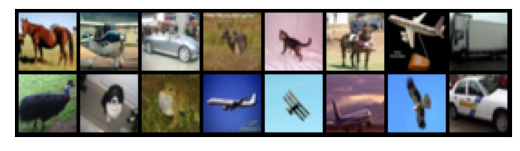

In [9]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

show(make_grid(images[:16], normalize=True, value_range=(-1, 1)))

### Train Model

In [12]:
def train(data_loader: DataLoader, n_epoch: int = 1000, device: str = "cuda:0") -> None:
    # Initializing the DDPM model with a specified U-Net architecture, beta values, and timesteps
    ddpm = DDPM(
        eps_model=NaiveUnet(3, 3, n_feat=256), betas=(1e-4, 0.02), n_timesteps=1000
    )
    ddpm.to(device)

    # Setting up the optimizer for training (Adam optimizer with a learning rate of 1e-5)
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
    scaler = torch.cuda.amp.GradScaler()

    # Create a list to store the average loss of each epoch
    epoch_losses = []

    # Setting up the plot
    fig, ax = plt.subplots()
    display_handle = display(fig, display_id=True)

    # Main training loop
    for epoch in tqdm(range(n_epoch), desc="Processing epoch", leave=False):
        ddpm.train()  # Setting the model to training mode

        pbar = tqdm(data_loader, desc="loss:", leave=False)
        loss_ema = None  # Exponential moving average of loss for display
        batch_losses = []  # List to store the loss of each batch
        for x, _ in pbar:
            optimizer.zero_grad()  # Zeroing the gradients

            x = x.to(device)  # Moving the batch of images to the specified device

            with torch.autocast(device_type=device, dtype=torch.float16):
                loss = ddpm(x)  # Forward pass to compute the loss

            scaler.scale(loss).backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm.parameters(), 1.0)
            scaler.step(optimizer)  # Update model parameters
            scaler.update()  # Updates the scale for next iteration.

            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_description(f"loss: {loss.item():.4f}")

        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)

        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)

        # Redraw the plot
        display_handle.update(fig)

        # Evaluation and sample generation
        ddpm.eval()
        with torch.no_grad():
            if epoch % 1 == 0:
                samples = ddpm.sample(8, (3, 32, 32), device)
                sample_set = torch.cat([samples, x[:8]], dim=0)
                grid = make_grid(
                    sample_set, normalize=True, value_range=(-1, 1), nrow=4
                )
                save_image(grid, f"./images_speed/ddpm_sample_{epoch}.png")

            # Saving the model weights
            torch.save(ddpm.state_dict(), f"./ddpm_weights_speed.pth")

    plt.close()

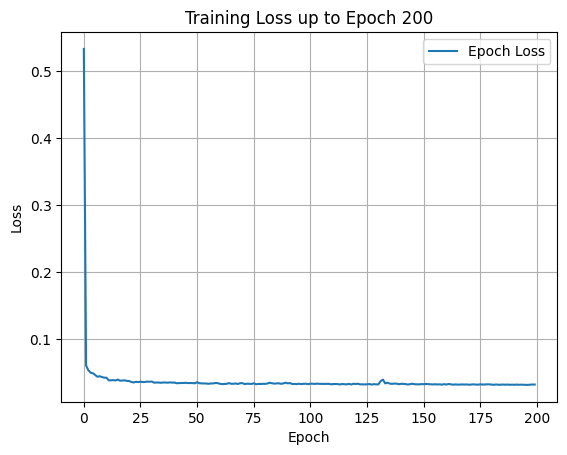

Processing epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

/app/design_analysis_server/tools/experimental/lib/design_data/notebook_cluster.runfiles/pypi_torch/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

loss::   0%|          | 0/196 [00:00<?, ?it/s]

In [13]:
train(data_loader=dataloader, n_epoch=200, device="cuda")